In [2]:
import os
import sklearn
import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

from skimage import io
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from scipy.spatial.distance import pdist
from sklearn.externals import joblib
from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgb

In [1]:
import expression_recognition.api as exp_recog
import expression_recognition.feature_utils as futils

/home/akrikunov/anaconda3/lib/python3.6/site-packages/expression_detector-0.1.2-py3.6.egg/expression_recognition/detectors.py:14: UserWarning: Model "expression_recognition/models/mouth_opened_model.sav" not found.
            Please prepare models using "experiments/models_selection.ipynb" and rebuild package


# Examples dataset

In [3]:
path = "../data/example_data/"
path_all = join(path, "images/")
path_smile = join(path, "smile/")
path_open = join(path, "open_mouth/")

In [4]:
def find_images(folder):
    return [f for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".jpg")]

In [5]:
all_files = find_images(path_all)
smile_files = find_images(path_smile)
open_files = find_images(path_open)

In [6]:
def label(fl):
    if fl in smile_files:
        return 'smile'
    elif fl in open_files:
        return 'open'
    return None

labled_files = [(f, label(f)) for f in all_files]

In [7]:
y_smile_all, y_open_all = [[1 if l==ds else 0 for _, l in labled_files] for ds in ['smile', 'open']]

In [8]:
%%time
example_files = [join(path_all, f) for f, _ in labled_files]
example_data, indexes = exp_recog.compute_landmarks(example_files, True)

CPU times: user 6min 58s, sys: 2.12 s, total: 7min 1s
Wall time: 7min 1s


In [9]:
y_smile = [y for (i, y) in zip(indexes, y_smile_all) if i==1]

In [10]:
X_example = futils.flatten(example_data)
X_example_dists = futils.to_dists_dataset(example_data)

mouthes_data = futils.get_mouthes_only(example_data)
X_mouthes = futils.flatten(mouthes_data) 
X_mouthes_dists = futils.to_dists_dataset(mouthes_data)

#  LFW dataset

In [20]:
lfw_ds_files = []
for folder,_ ,files in os.walk("../data/lfw_filtered/"):
    for file in files:
        if file.endswith(".jpg"):
            lfw_ds_files.append(join(folder, file))
            
with open("../data/lfw_filtered/SMILE_list.txt", "r") as f:
    lfw_smile_list  = [l.strip() for l in f.readlines()]

lfw_labels = []
for file in lfw_ds_files:
    fname = file.split('/')[-1]
    l = 1 if fname in lfw_smile_list else 0
    lfw_labels.append(l)

In [22]:
%%time
X_lfw, indexes = exp_recog.compute_landmarks(lfw_ds_files, True)
y_lfw = [y for (i, y) in zip(indexes, lfw_labels) if i==1]

CPU times: user 14min 45s, sys: 727 ms, total: 14min 46s
Wall time: 14min 48s


In [23]:
with open("../data/X_lfw.pkl", "wb") as f:
    pickle.dump(X_lfw, f)
with open("../data/y_lfw.pkl", "wb") as f:
    pickle.dump(y_lfw, f)    
    
#with open("./X_lfw.pkl", "rb") as f:
#    X_lfw = pickle.load(f)
#with open("../data/y_lfw.pkl", "rb") as f:
#    y_lfw = pickle.load(f) 

In [24]:
rus = RandomUnderSampler()

In [25]:
#Raw features
X_lfw_flatten = futils.flatten(X_lfw)
X_lfw_resampled, y_lfw_resampled = rus.fit_sample(X_lfw_flatten, y_lfw)

#Mouthes only
mouthes_lfw = futils.get_mouthes_only(X_lfw)
X_lfw_mouthes = futils.flatten(mouthes_lfw) 
X_lfw_mouthes_resampled, y_lfw_mouthes_resampled = rus.fit_sample(X_lfw_mouthes, y_lfw)

## Landmarks distances
X_lfw_dists = futils.to_dists_dataset(X_lfw)
X_lfw_dists_resampled, y_lfw_dists_resampled = rus.fit_sample(X_lfw_dists, y_lfw)

#Mouthes distances

X_lfw_mouthes_dists = futils.to_dists_dataset(mouthes_lfw)
X_lfw_mouthes_dists_resampled, y_lfw_mouthes_resampled = rus.fit_sample(X_lfw_mouthes_dists, y_lfw)

In [31]:
features = [(X_lfw_resampled, y_lfw_resampled), 
            (X_lfw_mouthes_resampled, y_lfw_mouthes_resampled),
            (X_lfw_dists_resampled, y_lfw_dists_resampled),
            (X_lfw_mouthes_dists_resampled, y_lfw_mouthes_resampled)]
names = ["landmarks", "mouthes landmarks", "landmarks distances", "mouthes distances"]
validations = [X_example, X_mouthes, X_example_dists, X_mouthes_dists]

## SVM

In [32]:
clf = svm.SVC(kernel='linear', C=1, probability=True)

for (feature, labels), feat_name, validation in zip(features, names, validations):
    lfw_score = cross_val_score(clf, feature, labels, scoring="roc_auc", cv=6, n_jobs=-1)
    print("{} crossval:\tmean auc: {:.3}\tstd auc: {:.3}".format(feat_name, np.mean(lfw_score), np.std(lfw_score)))
          
    clf.fit(feature, labels)
    predict_p = clf.predict_proba(validation)[:, 1]
    print("{} examples:\tauc {:.3}\n".format(feat_name, roc_auc_score(y_smile, predict_p)))

landmarks crossval:	mean auc: 0.904	std auc: 0.0236
landmarks examples:	auc 0.881

mouthes landmarks crossval:	mean auc: 0.905	std auc: 0.024
mouthes landmarks examples:	auc 0.867

landmarks distances crossval:	mean auc: 0.919	std auc: 0.0259
landmarks distances examples:	auc 0.901

mouthes distances crossval:	mean auc: 0.897	std auc: 0.0208
mouthes distances examples:	auc 0.887



## LGBM

In [28]:
lgb_clf = lgb.LGBMClassifier()

for (feature, labels), feat_name, validation in zip(features, names, validations):
    lfw_score = cross_val_score(lgb_clf, feature, labels, scoring="roc_auc", cv=6, n_jobs=-1)
    print("{} crossval:\tmean auc: {:.3}\tstd auc: {:.3}".format(feat_name, np.mean(lfw_score), np.std(lfw_score)))
          
    clf.fit(feature, labels)
    predict_p = clf.predict_proba(validation)[:, 1]
    print("{} examples:\tauc {:.3}\n".format(feat_name, roc_auc_score(y_smile, predict_p)))

landmarks crossval:	mean auc: 0.903	std auc: 0.018
landmarks examples:	auc 0.881

mouthes landmarks crossval:	mean auc: 0.896	std auc: 0.0297
mouthes landmarks examples:	auc 0.867

landmarks distances crossval:	mean auc: 0.901	std auc: 0.0229
landmarks distances examples:	auc 0.901



The best model is SVM with distances features. Save it as smile model.

In [33]:
clf = svm.SVC(kernel='linear', C=1, probability=True)
clf.fit(X_lfw_dists_resampled, y_lfw_dists_resampled)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
joblib.dump(clf, "../expression_recognition/models/smile_model.sav")

['../models/smile_model.sav']

# Open faces

In [11]:
y_open = [y for (i, y) in zip(indexes, y_open_all) if i==1]

In [12]:
features_open_mouthes = [(X_example, y_open), 
            (X_mouthes, y_open),
            (X_example_dists, y_open),
            (X_mouthes_dists, y_open)]
names_open_mouthes = ["landmarks", "mouthes landmarks", "landmarks distances", "mouthes distances"]

clf = svm.SVC(kernel='linear', C=1, probability=True)

for (feature, labels), feat_name in zip(features_open_mouthes, names_open_mouthes):
    lfw_score = cross_val_score(clf, feature, labels, scoring="roc_auc", cv=6, n_jobs=-1)
    print("{} crossval:\tmean auc: {:.3}\tstd auc: {:.3}".format(feat_name, np.mean(lfw_score), np.std(lfw_score)))


landmarks crossval:	mean auc: 0.934	std auc: 0.0584
mouthes landmarks crossval:	mean auc: 0.938	std auc: 0.0629
landmarks distances crossval:	mean auc: 0.937	std auc: 0.0621
mouthes distances crossval:	mean auc: 0.932	std auc: 0.0663


In [13]:
clf_open = svm.SVC(kernel='linear', C=1, probability=True)
clf_open.fit(X_mouthes, y_open)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
joblib.dump(clf_open, "../expression_recognition/models/mouth_opened_model.sav")

['../expression_recognition/models/mouth_opened_model.sav']

In [17]:
from sklearn.metrics import f1_score

In [40]:
f1 = []
probs = clf_open.predict_proba(X_mouthes)[:,1]
for th in np.linspace(0, 1, 20):
    d = [1 if p>=th else 0 for p in probs]
    f1.append(f1_score(y_open, d))

/home/akrikunov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


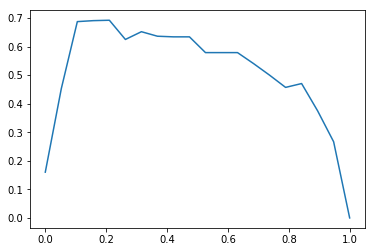

In [41]:
plt.plot(np.linspace(0, 1, 20), f1)

In [37]:
probs.max()

0.9999814976228895